# **Nilesh Hegde**
## **FAKE NEWS DETECTION**

This notebooks contains code related to PyTorch based BERT classifier.

# **NOTE - Please upload the dataset 'data.csv' before executing the notebook**

# **IMPORT LIBRARIES**

Import libraries and modules needed for various functions and uses in this notebook. If needed please install *pandas, numpy, torchvision* if not modules don't exist

In [ ]:
import torch
import pandas as pd
import numpy as np
import re
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset, RandomSampler, SequentialSampler
import time
import datetime
import random
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# **Check for GPU**

Check if GPUs are available. If they are use them as devices to evaluate model.

In [ ]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


# **Check for Transformers**

Check if transformers module has been installed. If not install it.

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 57.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.2 MB/s eta 0:00:00


# **Read data and Preprocess it**

Read the data from csv file and preprocess it by - 
1. Drop empty cell rows 
2. Concate title and text columns 
2. Convert to lower case
4. Remove puctuations.

In [ ]:
df = pd.read_csv('data.csv', encoding='UTF-8')
df = df.sample(frac=1).reset_index(drop=True)
print('Number of training sentences: {:,}\n'.format(df.shape[0]))
df['text'].dropna(inplace=True)
df['text'] = df['text'] + ' ' + df['title']
df['text'] = [str(entry).lower() for entry in df['text']]
df['text'] = [re.sub(r"""
               [,.;@#?!&$-]+  # Accept one or more copies of punctuation
               \ *           # plus zero or more copies of a space,
               """,
               " ",          # and replace it with a single space
               entry, flags=re.VERBOSE) for entry in df['text']]
sentences = df['text'].values
labels = df['label'].values

Number of training sentences: 20,800



# **Load Pre-trained Model**

Load the pre-trained BERT sequence classification model from transformers module and initialize BERT Tokenizer.

In [ ]:
from transformers import (
                          BertForSequenceClassification,
                          BertTokenizer,
                          RobertaForSequenceClassification,
                          RobertaTokenizer,
                          AdamW,
                          get_linear_schedule_with_warmup
                          )
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                                num_labels = 2,  
                                                                output_attentions = False,
                                                                output_hidden_states = False
                                                          )
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

# **Maximum length of sentence**

Find the maximum length of sentences after tokenizing using BERT Toeknizer

In [ ]:
max_len_bert = 0
for sent in sentences:
    input_ids_bert = bert_tokenizer.encode(sent, add_special_tokens=True)
    max_len_bert = max(max_len_bert, len(input_ids_bert))
print('Max sentence length BERT: ', max_len_bert)

Token indices sequence length is longer than the specified maximum sequence length for this model (4980 > 512). Running this sequence through the model will result in indexing errors


Max sentence length BERT:  114222


# **Tokenize all of the sentences and map the tokens to thier word IDs.**

For every sentence - 
1. Tokenize the sentence.
2. Prepend the `[CLS]` token to the start.
3. Append the `[SEP]` token to the end.
4. Map tokens to their IDs.
5. Pad or truncate the sentence to `max_length`
6. Create attention masks for [PAD] tokens.

Then convert lists to tensors.

In [ ]:
bert_input_ids = []
bert_attention_masks = []
sentence_ids = []
counter = 0
for sent in sentences: 
    bert_encoded_dict = bert_tokenizer.encode_plus(
                        sent,                      
                        add_special_tokens = True, 
                        max_length = 120,           
                        pad_to_max_length = True,
                        return_attention_mask = True,   
                        return_tensors = 'pt',     
                   )  
    bert_input_ids.append(bert_encoded_dict['input_ids'])
    bert_attention_masks.append(bert_encoded_dict['attention_mask'])
    sentence_ids.append(counter)
    counter  = counter + 1
bert_input_ids = torch.cat(bert_input_ids, dim=0)
bert_attention_masks = torch.cat(bert_attention_masks, dim=0)
labels = torch.tensor(labels)
sentence_ids = torch.tensor(sentence_ids)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


# **Perform Train-Validation-Test split**

The first 15000 rows of data is for training and validation. The rest are for testing. Also created a function to remove indices from tensors.

In [ ]:
def index_remover(tensordata):
    input_ids = []
    attention_masks = []
    labels = []
    for a,b,c,d in tensordata:
        input_ids.append(b.tolist())
        attention_masks.append(c.tolist())
        labels.append(d.tolist())
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    labels = torch.tensor(labels)
    final_dataset =  TensorDataset(input_ids, attention_masks, labels)
    return final_dataset

In [ ]:
torch.manual_seed(0)
bert_dataset = TensorDataset(sentence_ids, bert_input_ids, bert_attention_masks, labels)
bert_train_dataset = torch.utils.data.Subset(bert_dataset , range(12000))
bert_val_dataset = torch.utils.data.Subset(bert_dataset , range(12000,15000))
bert_test_dataset = torch.utils.data.Subset(bert_dataset , range(15000,len(bert_dataset)))
sentence_ids_list_valid = []
for a,b,c,d in bert_val_dataset:
    sentence_ids_list_valid.append(a.tolist())
bert_train_dataset = index_remover(bert_train_dataset)
bert_val_dataset = index_remover(bert_val_dataset)
label_temp_list = []
for a,b,c in bert_train_dataset:
    label_temp_list.append(c)
print('{:>5,} training samples'.format(12000))
print('{:>5,} training samples with real news'.format(sum(label_temp_list)))
label_temp_list = []
for a,b,c in bert_val_dataset:
    label_temp_list.append(c)
print('{:>5,} validation samples'.format(3000))
print('{:>5,} validation samples with real news'.format(sum(label_temp_list)))

12,000 training samples
6,026 training samples with real news
3,000 validation samples
1,474 validation samples with real news


# **Dataloaders and Hyperparameters**

Create dataloaders for training and validation sets and initialize *Adamw* optimizer. Also initialize a BERT scheduler. Initialize hyperparameters *#epochs* and *batch size*

In [ ]:
batch_size = 32
bert_train_dataloader = DataLoader(
            bert_train_dataset,  
            sampler = RandomSampler(bert_train_dataset), 
            batch_size = batch_size 
        )
bert_validation_dataloader = DataLoader(
            bert_val_dataset, 
            sampler = SequentialSampler(bert_val_dataset), 
            batch_size = batch_size 
        )
bert_optimizer = torch.optim.AdamW(bert_model.parameters(),
                  lr = 5e-5, 
                  eps = 1e-8 
                )
epochs = 10
total_steps = len(bert_train_dataloader) * epochs
bert_scheduler = get_linear_schedule_with_warmup(bert_optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

# **Auxilary Functions**

The following are auxilary function created to find accuarcies and time taken to execute evaluation in *hh:mm::ss* format

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

# **Training the Model**

Train the BERT model and evaluate performance on validation set.

In [ ]:
seed_val = 100
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
bert_training_stats = []
total_t0 = time.time()
least_val_loss = 10000
best_bert_model = None
for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    t0 = time.time()
    total_train_loss = 0
    bert_model.train()
    for step, batch in enumerate(bert_train_dataloader):
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(bert_train_dataloader), elapsed))
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        bert_model.zero_grad()
        loss, logits = bert_model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels).to_tuple()
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(bert_model.parameters(), 1.0)
        bert_optimizer.step()
        bert_scheduler.step()
    avg_train_loss = total_train_loss / len(bert_train_dataloader)
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.4f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
    

    print("")
    print("Running Validation...")
    t0 = time.time()
    bert_model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    for batch in bert_validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        with torch.no_grad():        
            (loss, logits) = bert_model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels).to_tuple()
        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)
    
    avg_val_accuracy = total_eval_accuracy / len(bert_validation_dataloader)
    print("  Accuracy: {0:.4f}".format(avg_val_accuracy))
    avg_val_loss = total_eval_loss / len(bert_validation_dataloader)
    if avg_val_loss < least_val_loss:
        least_val_loss = avg_val_loss 
        best_bert_model = bert_model
    validation_time = format_time(time.time() - t0)
    print("  Validation Loss: {0:.4f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    bert_training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 10 ========
Training...
  Batch    40  of    375.    Elapsed: 0:00:29.
  Batch    80  of    375.    Elapsed: 0:00:55.
  Batch   120  of    375.    Elapsed: 0:01:20.
  Batch   160  of    375.    Elapsed: 0:01:45.
  Batch   200  of    375.    Elapsed: 0:02:11.
  Batch   240  of    375.    Elapsed: 0:02:37.
  Batch   280  of    375.    Elapsed: 0:03:02.
  Batch   320  of    375.    Elapsed: 0:03:27.
  Batch   360  of    375.    Elapsed: 0:03:53.

  Average training loss: 0.1533
  Training epcoh took: 0:04:03

Running Validation...
  Accuracy: 0.9764
  Validation Loss: 0.0642
  Validation took: 0:00:20

======== Epoch 2 / 10 ========
Training...
  Batch    40  of    375.    Elapsed: 0:00:25.
  Batch    80  of    375.    Elapsed: 0:00:51.
  Batch   120  of    375.    Elapsed: 0:01:16.
  Batch   160  of    375.    Elapsed: 0:01:42.
  Batch   200  of    375.    Elapsed: 0:02:07.
  Batch   240  of    375.    Elapsed: 0:02:33.
  Batch   280  of    375.    Elapsed: 0:02:58.
 

# **Loss and Accuracy Plots**

Graphs of loss and accuracy of the model on training and validation data.

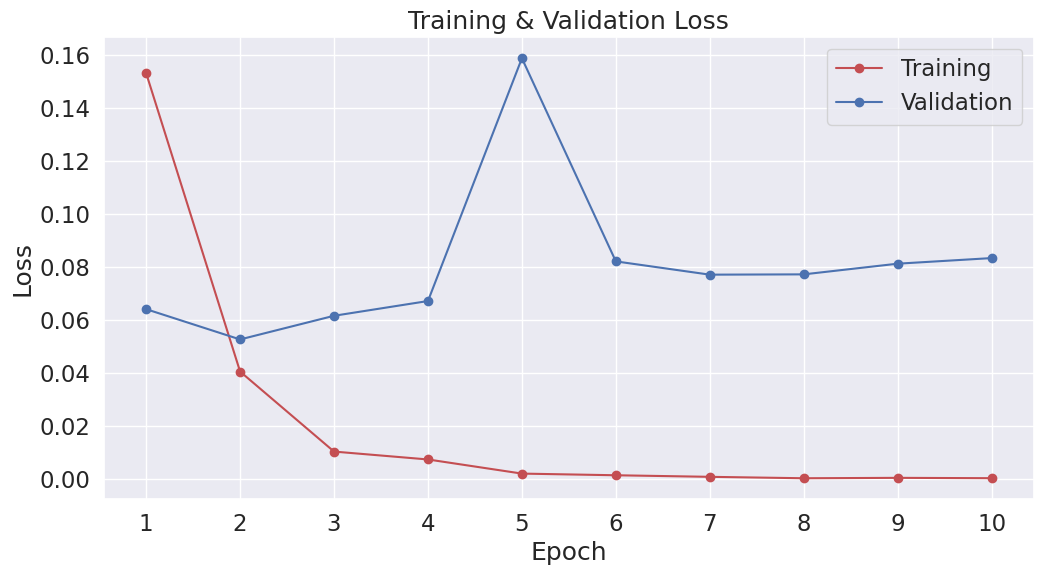

In [ ]:
df_stats = pd.DataFrame(data=bert_training_stats)
df_stats = df_stats.set_index('epoch')
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(df_stats['Training Loss'], 'r-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'b-o', label="Validation")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.show()

# **Performance Evaluation**

Evaluate the performance of the model on test dataset using the BERT model with least validation loss.

In [ ]:
print("Running performance evaluation...")
bert_test_dataset = index_remover(bert_test_dataset)
bert_test_dataloader = DataLoader(
            bert_test_dataset, 
            sampler = SequentialSampler(bert_test_dataset), 
            batch_size = batch_size 
        )
best_bert_model.eval()
predictions , true_labels = [], []
for batch in bert_test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        outputs = bert_model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    predictions.append(logits)
    true_labels.append(label_ids)
flat_predictions = np.concatenate(predictions, axis=0)
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
data_test = df.iloc[15000:]
actual_value = data_test['label'].to_numpy()
print('Accuracy on test dataset is',round(metrics.accuracy_score(flat_predictions, actual_value),4))

Running performance evaluation...
Accuracy on test dataset is 0.9857
